# Make `housing_nl` table in Postgresql database 

- add neighborhood, municipality, and province info to `bag_pand` and `bag_vbo`
- for buildings in bag that aren't connected to units (vbo): 
    - estimate function
    - estimate sqm 

**Next step:**
estimate embodied emissions for each row in housing_nl

**Issue:**
The resulting table has a few buildings that are obviously not housing (e.g. industrial buildings, hospitals)...etc. Need to further refine method of guessing building function. 

In [2]:
from sqlalchemy import create_engine, inspect
import subprocess
import pandas as pd
import geopandas as gpd
import psycopg2
from psycopg2 import sql
import plotly.express as px
import matplotlib.pyplot as plt
import time
import sys

# Define variables

In [3]:
# define table names for queries
bag_pand_table_name = 'bag_pand' # bag_pand_delft
bag_vbo_table_name = 'bag_vbo' # bag_vbo_delft
housing_table_name = 'housing_nl' # housing_delft
ahn_table_name = 'ahn_elevation' # ahn_elevation_delft

# define database connection
db_name = "urbanmining"
username = "postgres"
password = "Tunacompany5694!"
host = "localhost"  # or your host if it's not local
port = "5432"  # default port for PostgreSQL

# SQL queries 
SQL queries as text, to be run by psycopg2 

In [4]:
###############################################################################################################################################################################
# MAKE DELFT SAMPLE
###############################################################################################################################################################################

# make sample of bag_pand, bag_vbo and ahn_elevation for Delft
query_make_delft_sample = ''' 
DROP TABLE IF EXISTS bag_pand_delft;
CREATE TABLE bag_pand_delft AS 
WITH delft AS (
    SELECT * FROM nl_gemeentegebied WHERE naam = 'Delft'
)
SELECT b.*
FROM bag_pand b
JOIN delft d
ON ST_Contains(d.geom, b.geom_28992);

DROP TABLE IF EXISTS bag_vbo_delft;
CREATE TABLE bag_vbo_delft AS
WITH delft AS (
    SELECT * FROM nl_gemeentegebied WHERE naam = 'Delft'
)
SELECT b.*
FROM bag_vbo b
JOIN delft d
ON ST_Contains(d.geom, b.geom_28992);

DROP TABLE IF EXISTS ahn_elevation_delft; 
CREATE TABLE ahn_elevation_delft AS

WITH delft AS (
	SELECT * FROM nl_gemeentegebied WHERE naam = 'Delft'
)

SELECT 
	d.naam AS municipality, d.ligt_in_provincie_naam AS province, 
	a.*
FROM ahn_elevation a 
JOIN delft d 
ON ST_Intersects(a.rast_geom, d.geom); 
'''

###############################################################################################################################################################################
# ADD MUNICIPALITY AND PROVINCE INFO TO AHN_ELEVATION, BAG_PAND, BAG_VBO, AND LANDUSE_NL
# This allows queries to be run by municipality, which dramatically reduces runtime 
###############################################################################################################################################################################

# add municipality and province columns to ahn_elevation 
query_add_municipality_ahn = f''' 
ALTER TABLE {ahn_table_name} ADD COLUMN IF NOT EXISTS municipality VARCHAR;
ALTER TABLE {ahn_table_name} ADD COLUMN IF NOT EXISTS province VARCHAR;

WITH municipality AS (
	SELECT * FROM nl_gemeentegebied WHERE naam = %s 
)
	
UPDATE {ahn_table_name} 
SET 
	municipality = m.naam, 
	province = m.ligt_in_provincie_naam
FROM municipality m 
WHERE ST_Intersects({ahn_table_name}.rast_geom, m.geom); 
''' 

# add columns to bag_pand and bag_vbo
query_add_columns_bag_pand = f''' 
ALTER TABLE {bag_pand_table_name} ADD COLUMN neighborhood_code VARCHAR;
ALTER TABLE {bag_pand_table_name} ADD COLUMN neighborhood VARCHAR;
ALTER TABLE {bag_pand_table_name} ADD COLUMN municipality VARCHAR;
ALTER TABLE {bag_pand_table_name} ADD COLUMN province VARCHAR;
'''
query_add_columns_bag_vbo = f''' 
ALTER TABLE {bag_vbo_table_name} ADD COLUMN neighborhood_code VARCHAR;
ALTER TABLE {bag_vbo_table_name} ADD COLUMN neighborhood VARCHAR;
ALTER TABLE {bag_vbo_table_name} ADD COLUMN municipality VARCHAR;
ALTER TABLE {bag_vbo_table_name} ADD COLUMN province VARCHAR;
'''

# add municipality and province columns to bag_pand and bag_vbo
# two %s, the municipality name, like 'Delft'
query_match_bag_to_admin_boundaries = f''' 
WITH municipality AS (
	SELECT * FROM nl_buurten WHERE municipality_name = %s
)
	
UPDATE {bag_pand_table_name}
SET 
	neighborhood_code = b.neighborhood_code, 
	neighborhood = b.neighborhood, 
    municipality = b.municipality_name,
    province = b.province
FROM municipality b
WHERE ST_Intersects({bag_pand_table_name}.geom_28992, b.neighborhood_geom);

WITH municipality AS (
	SELECT * FROM nl_buurten WHERE municipality_name = %s
)
	
UPDATE {bag_vbo_table_name}
SET 
	neighborhood_code = b.neighborhood_code, 
	neighborhood = b.neighborhood, 
    municipality = b.municipality_name,
    province = b.province
FROM municipality b
WHERE ST_Intersects({bag_vbo_table_name}.geom_28992, b.neighborhood_geom);
'''

# create landuse_nl table according to the following columns: 
query_create_landuse_nl_table = '''
DROP TABLE IF EXISTS landuse_nl;
CREATE TABLE landuse_nl (
	gml_id VARCHAR, description VARCHAR, geom_28992 GEOMETRY,
    municipality VARCHAR, province VARCHAR
);
''' 

# add buurt, municipality, and province info to landuse table
# one %s, the municipality name, like 'Delft'
query_add_buurtInfo_to_landuse_nl = f''' 
INSERT INTO landuse_nl (
	gml_id, description, geom_28992, municipality, province
)

WITH municipality AS (
	SELECT * 
	FROM nl_gemeentegebied
	WHERE naam = %s 
), 
landuse_municipality AS (
	SELECT 
    	l.gml_id, l.description AS landuse, l.geom_28992, 
    	m.naam AS municipality, m.ligt_in_provincie_naam AS province
	FROM existinglanduseobject l 
	JOIN municipality m 
	ON 
		l.geom_28992 && m.geom 
		AND ST_Intersects(l.geom_28992, m.geom)
)

SELECT * FROM landuse_municipality
'''

###############################################################################################################################################################################
# ADD RENOVATION INFO TO BAG_PAND
# This includes the following types of renovation: 
# - pre-2020 renovations that were not captured in the BAG data since 'Verbouwing pand' wasn't introduced yet 
# - transformation of building from non-housing to housing function 
# - transformation of building from adding new units 
###############################################################################################################################################################################

# add renovation column to bag_pand
query_add_renovation_column = f'''
ALTER TABLE {bag_pand_table_name} DROP COLUMN IF EXISTS renovation_pandingebruiknietingemeten;
ALTER TABLE {bag_pand_table_name} DROP COLUMN IF EXISTS renovation;
ALTER TABLE {bag_pand_table_name} ADD COLUMN IF NOT EXISTS renovation VARCHAR;
CREATE INDEX IF NOT EXISTS idx_bag_pand_municipality_registration_start ON {bag_pand_table_name} (municipality, (LEFT(registration_start, 4)::INTEGER));
CREATE INDEX IF NOT EXISTS idx_bag_pand_id_pand_registration_start ON {bag_pand_table_name} (id_pand, registration_start);
CREATE INDEX IF NOT EXISTS idx_bag_pand_status ON {bag_pand_table_name} (status);
'''

# get renovations before 2020 
query_add_pre2020_renovations = f'''
INSERT INTO {bag_pand_table_name} (
	renovation, id_pand, geometry, build_year, status, document_date, document_number, 
	registration_start, registration_end, geom, geom_28992, 
	neighborhood_code, neighborhood, municipality, province
)

WITH bag_pand_municipality AS (
	SELECT * FROM bag_pand
	WHERE 
		municipality = %s 
		AND LEFT(registration_start, 4)::INTEGER < 2020
), 
ranked_pand_sample AS (
    SELECT *,
           LAG(status) OVER (PARTITION BY id_pand ORDER BY registration_start) AS previous_status
    FROM bag_pand_municipality
)
SELECT 
	CASE 
		WHEN 
        	status = 'Pand in gebruik (niet ingemeten)' 
    		AND previous_status IS NOT NULL 
            AND previous_status = 'Pand in gebruik'  
        THEN 'Verbouwing pand'
		ELSE 'Not verbouwing pand'
	END AS renovation, 
	id_pand, geometry, build_year, status, document_date, document_number, 
	registration_start, registration_end, geom, geom_28992, 
	neighborhood_code, neighborhood, municipality, province
FROM ranked_pand_sample; 

DELETE FROM {bag_pand_table_name}
WHERE 
	municipality = %s
	AND LEFT(registration_start, 4)::INTEGER < 2020
	AND renovation IS NULL; 

UPDATE {bag_pand_table_name}
SET renovation = 'Verbouwing pand'
WHERE status = 'Verbouwing pand' AND municipality = %s;
'''

# add transformations from non-housing to housing 
query_add_transformation_function_change = f''' 
DROP TABLE IF EXISTS transformed_housing_buildings; 

-- delete rows about transformation (from previous queries)
DELETE FROM {bag_pand_table_name}
WHERE 
	municipality = %s
	AND renovation = 'transformation - function change'; 

-- create temp table transformed_housing_buildings
CREATE TEMP TABLE transformed_housing_buildings AS 
WITH bag_vbo_municipality AS (
	SELECT * 
	FROM bag_vbo 
	WHERE municipality = %s
), 
function_counts AS (
    SELECT 
        id_vbo,
        COUNT(DISTINCT function) AS n_functions
    FROM bag_vbo_municipality
    GROUP BY id_vbo
), 
idvbos_functionchange AS (
	SELECT DISTINCT id_vbo 
	FROM function_counts 
	WHERE n_functions > 1
), 
bag_vbo_functionchange AS (
	SELECT b.*
	FROM bag_vbo_municipality b
	JOIN idvbos_functionchange i
	ON b.id_vbo = i.id_vbo
), 
previousfunction AS (
	SELECT 
		LAG(function) OVER (PARTITION BY id_vbo ORDER BY registration_start) AS previous_function, 
		* 
	FROM bag_vbo_functionchange
), 
transformed_housing_units AS (
	SELECT * 
	FROM previousfunction
	WHERE 
		function = 'woonfunctie' 
		AND previous_function != 'woonfunctie'
		AND previous_function IS NOT NULL
), 
transformed_housing_buildings AS (
	SELECT id_pand, LEFT(registration_start, 4) AS year
	FROM transformed_housing_units
	GROUP BY id_pand, LEFT(registration_start, 4)
)

SELECT * FROM transformed_housing_buildings; 

-- update renovation column of {bag_pand_table_name} with transformation 
-- where there was a match in id_pand and registration year 
UPDATE {bag_pand_table_name} b
SET renovation = 'transformation - function change'
FROM transformed_housing_buildings t 
WHERE 
	b.id_pand = t.id_pand 
	AND municipality = %s
	AND LEFT(b.registration_start, 4) = t.year;

-- add new rows to {bag_pand_table_name} on transformation 
-- where there was no match in id_pand and registration year 
INSERT INTO {bag_pand_table_name} (
	id_pand, geometry, build_year, status, document_date, registration_start, registration_end, 
	geom, geom_28992, neighborhood_code, neighborhood, municipality, province, renovation
)
WITH bag_pand_municipality AS (
	SELECT * 
	FROM bag_pand
	WHERE municipality = %s
), 	
transformation_notinbag AS (
	SELECT t.* 
	FROM transformed_housing_buildings t 
	LEFT JOIN bag_pand_municipality b 
	ON 
		b.id_pand = t.id_pand 
		AND LEFT(b.registration_start, 4) = t.year
	WHERE b.id_pand IS NULL
), 
ranked_bag_pand AS (
    SELECT 
		t.id_pand, b.geometry, b.build_year, b.status, 
		year || '-01-01' AS document_date, year || '-01-01' AS registration_start, year || '-12-31' AS registration_end, 
		b.geom, b.geom_28992, b.neighborhood_code, b.neighborhood, b.municipality, b.province, 
		'transformation - function change (inserted)' AS renovation, 
        ROW_NUMBER() OVER (PARTITION BY t.id_pand ORDER BY b.registration_start DESC) AS rn
    FROM 
        transformation_notinbag t
    JOIN 
        bag_pand_municipality b 
    ON 
        b.id_pand = t.id_pand
    WHERE 
        b.registration_start <= t.year
)
SELECT 
	id_pand, geometry, build_year, status, document_date, registration_start, registration_end, 
	geom, geom_28992, neighborhood_code, neighborhood, municipality, province, renovation
FROM ranked_bag_pand
WHERE rn = 1;
''' 

###############################################################################################################################################################################
# ESTIMATE HOUSING FUNCTION AND SQM 
# Some buildings in the BAG dataset don't have info on function and sqm, so we need to estimate it: 
# - function is estimated using land use data and function of nearest buildings within a 50m radius 
# - sqm is estimated using AHN elevation data and building footprint
###############################################################################################################################################################################

# create housing_nl table
query_create_housing_nl_table = f''' 
DROP TABLE IF EXISTS {housing_table_name};
CREATE TABLE {housing_table_name} (
    function TEXT,
    sqm BIGINT,
    id_pand VARCHAR,
    geometry VARCHAR,
    build_year VARCHAR,
    status VARCHAR,
    document_date VARCHAR,
    document_number VARCHAR,
    registration_start VARCHAR,
    registration_end VARCHAR,
    geom GEOMETRY,             -- Assuming GEOMETRY is the intended type
    geom_28992 GEOMETRY,       -- Assuming GEOMETRY is the intended type
    neighborhood_code VARCHAR, -- Added column
    neighborhood VARCHAR,      -- Added column
    municipality VARCHAR,
    province VARCHAR
);
'''

# estimate housing function
# two %s, both are the municipality name, like 'Delft'
query_estimate_housing_function = f'''
INSERT INTO {housing_table_name} (
    function, sqm, id_pand, geometry, build_year, status, 
    document_date, document_number, registration_start, registration_end, 
    geom, geom_28992, neighborhood_code, neighborhood, municipality, province
)
	
-- select relevant units and buildings from BAG
WITH bag_vbo_sample AS (
	SELECT *
	FROM {bag_vbo_table_name}
	WHERE municipality = %s
), 
units AS (
	SELECT DISTINCT ON (id_vbo) * 
	FROM bag_vbo_sample
	WHERE 
		status = 'Verblijfsobject in gebruik' AND sqm::INTEGER < 9999
	ORDER BY id_vbo, status, registration_start, document_number
), 
bag_pand_sample_without_reno AS (
	SELECT * 
	FROM {bag_pand_table_name}
	WHERE municipality = %s 
), 
bag_pand_sample AS (
	SELECT 
		id_pand, geometry, build_year, 
		CASE 
			WHEN renovation = 'Verbouwing pand' THEN 'Verbouwing pand'
            WHEN renovation = 'transformation - function change (inserted)' THEN 'transformation - function change (inserted)'
            WHEN renovation = 'transformation - function change' THEN 'transformation - function change'
			ELSE status
		END AS status,
		document_date, document_number, 
		registration_start, registration_end, geom, geom_28992, 
		neighborhood_code, neighborhood, municipality, province
	FROM bag_pand_sample_without_reno
), 
buildings_construction_demolition AS (
	SELECT DISTINCT ON (id_pand, status) * 
	FROM bag_pand_sample
	WHERE status IN ('Bouw gestart', 'Pand gesloopt')
	ORDER BY id_pand, status, registration_start, document_number
), 
buildings_renovation AS (
	SELECT * 
	FROM bag_pand_sample
	WHERE status = 'Verbouwing pand'
), 
buildings AS (
	SELECT * FROM buildings_construction_demolition
	UNION ALL 
	SELECT * FROM buildings_renovation
), 

-- get buildings with unknown function
buildings_unknown AS (
	SELECT b.*
	FROM buildings b
	WHERE NOT EXISTS (
	    SELECT 1
	    FROM units u
	    WHERE u.id_pand = b.id_pand
	)
	ORDER BY b.id_pand, b.status, b.registration_start, b.document_number
),

-- find units within 50m radius of buildings_unknown
units_near_unknown AS (
    SELECT b.id_pand AS id_pand_b, u.*
    FROM units u
    JOIN buildings_unknown b 
	ON ST_DWithin(u.geom_28992, b.geom_28992, 50) AND u.neighborhood_code = b.neighborhood_code
), 
units_near_unknown_grouped AS (
	SELECT 
	    id_pand_b,
	    function,
	    COUNT(*) AS function_count
	FROM units_near_unknown
	GROUP BY id_pand_b, function
), 
units_near_unknown_ranked AS (
    SELECT 
        id_pand_b,
        function,
        function_count,
        ROW_NUMBER() OVER (PARTITION BY id_pand_b ORDER BY function_count DESC) AS rn
    FROM 
        units_near_unknown_grouped
), 

-- estimate unknown functions
housing_guesses AS (
	SELECT DISTINCT ON (id_pand_b)
		id_pand_b AS id_pand, function::TEXT AS function, NULL::BIGINT AS sqm
	FROM units_near_unknown_ranked 
	WHERE rn = 1 AND function = 'woonfunctie'
), 
housing_fromvbo AS (
	SELECT id_pand, SUM(sqm::INTEGER) AS sqm, 'woonfunctie' AS function
	FROM units
	WHERE function = 'woonfunctie'
	GROUP BY id_pand
), 
housing_combined AS (
	SELECT id_pand, function, sqm FROM housing_guesses
	UNION
	SELECT id_pand, function, sqm FROM housing_fromvbo 
), 
housing_final AS (
	SELECT 
		u.function AS function, u.sqm AS sqm, 
		b.*
	FROM buildings b 
	JOIN housing_combined u ON b.id_pand = u.id_pand 
)
SELECT * FROM housing_final; 
''' 

# estimate housing sqm with ahn elevation
# three %s, all three are the municipality name, like 'Delft'
query_estimate_housing_sqm = f'''
-- create indexes
CREATE INDEX IF NOT EXISTS idx_housing_nl_status_registration_start ON {housing_table_name} (status, registration_start);
CREATE INDEX IF NOT EXISTS idx_buildings_geom_28992 ON {housing_table_name} USING gist (geom_28992);
CREATE INDEX IF NOT EXISTS idx_ahn_elevation_rast_geom ON {ahn_table_name} USING gist (rast_geom);

ALTER TABLE {housing_table_name} 
ADD COLUMN IF NOT EXISTS ahn_version VARCHAR; 

INSERT INTO {housing_table_name} (
    sqm, ahn_version, function, id_pand, build_year, status, 
    document_date, registration_start, registration_end, 
    geom, geom_28992, 
	neighborhood_code, neighborhood, municipality, province
)

WITH buildings AS (
	SELECT 
		sqm, function, id_pand, build_year, status, 
	    document_date, registration_start, registration_end, 
	    geom, geom_28992, neighborhood_code, neighborhood, municipality, province
	FROM {housing_table_name}
	WHERE 
    	sqm IS NULL AND 
        ST_Area(geom_28992) < 100000 AND 
        municipality = %s
), 	

-- assign rows to ahn version
buildings_ahnversion AS (
	SELECT 
		CASE 		
			-- cases for bouw gestart 
			WHEN status = 'Bouw gestart' AND registration_start BETWEEN '2011-01-01' AND '2014-01-01' THEN 'ahn3'
			WHEN status = 'Bouw gestart' AND registration_start BETWEEN '2014-01-01' AND '2020-01-01' THEN 'ahn4'
			-- must be NULL, definitely don't have height data for buildings built after 2020 
			WHEN status = 'Bouw gestart' AND registration_start > '2020-01-01' THEN 'no ahn available' 
	
			-- cases for verbouwing pand 
			WHEN status = 'Verbouwing pand' AND registration_start BETWEEN '2011-01-01' AND '2013-06-30' THEN 'ahn2'
			WHEN status = 'Verbouwing pand' AND registration_start BETWEEN '2013-07-01' AND '2019-12-31' THEN 'ahn3' 
			WHEN status = 'Verbouwing pand' AND registration_start > '2020-01-01' THEN 'ahn4'
	
			-- cases for pand gesloopt 
			-- buildings demolished pre-2013 could use ahn2, but there is a risk that the elevation data was recorded during / after demolition. 
			-- for 100 percent accuracy, AHN1 data is needed, but (easily) available. (online has only DSM at 5m resolution) 
			WHEN status = 'Pand gesloopt' AND registration_start BETWEEN '2011-01-01' AND '2012-12-31' THEN 'ahn2' -- not 100 percent accurate 
			WHEN status = 'Pand gesloopt' AND registration_start BETWEEN '2013-01-01' AND '2019-12-31' THEN 'ahn2'
			WHEN status = 'Pand gesloopt' AND registration_start BETWEEN '2020-01-01' AND '2022-12-31' THEN 'ahn3'
			WHEN status = 'Pand gesloopt' AND registration_start >= '2023-01-01' THEN 'ahn4'
	
			-- other null cases 
			ELSE 'unforseen case'
		END AS ahn_version, 
		* 
	FROM buildings
), 

-- clip rasters by building footprint 
elevation_municipality AS (
	SELECT *
	FROM {ahn_table_name} 
	WHERE municipality = %s
), 
clipped_rasters AS (
    SELECT 
		b.ahn_version, b.function, b.id_pand, b.build_year, 
		b.status, b.document_date, b.registration_start, b.registration_end, 
		b.geom, b.geom_28992, b.neighborhood_code, b.neighborhood, b.municipality, b.province, 
        ST_Union(ST_Clip(r.rast, 1, b.geom_28992, -9999)) AS raster
    FROM buildings_ahnversion b
    LEFT JOIN elevation_municipality r
    ON ST_Intersects(r.rast_geom, b.geom_28992) AND b.ahn_version = r.ahn_version 
    GROUP BY
		b.ahn_version, b.function, b.id_pand, b.build_year, 
		b.status, b.document_date, b.registration_start, b.registration_end, 
		b.geom, b.geom_28992, b.neighborhood_code, b.neighborhood, b.municipality, b.province
), 

-- estimate n floors, sqm 
building_heights AS (
	SELECT
		*, ST_Area(geom_28992) AS footprint_sqm, 
		(ST_SummaryStats(raster)).count AS n_pixels, (ST_SummaryStats(raster)).max AS height
	FROM clipped_rasters
), 
building_nfloors AS (
	SELECT 
		CASE
			WHEN height < 4 THEN 1 
			WHEN height > 4 THEN ROUND(height / 3)
			ELSE 1 
		END AS n_floors, 
		* 
	FROM building_heights
), 
building_sqm_ahn AS (
	SELECT
		(n_floors * footprint_sqm)::INTEGER AS sqm, * 
	FROM building_nfloors
), 
to_insert AS (
    SELECT 
        sqm::INTEGER AS sqm, ahn_version, function, id_pand, build_year, 
        status, document_date, registration_start, registration_end, geom, 
        geom_28992, neighborhood_code, neighborhood, municipality, province
    FROM building_sqm_ahn
)
SELECT * FROM to_insert; 

-- delete row that didn't have sqm data 
DELETE FROM {housing_table_name}
WHERE sqm IS NULL AND municipality = %s; 
''' 

# add landuse column to housing_nl 
# (to be used for filtering out non-residential buildings)
query_add_landuse_column = f'''
ALTER TABLE {housing_table_name} ADD COLUMN IF NOT EXISTS landuse VARCHAR; 

-- assign the landuse 'Residential' to all buildings where function was not guessed
UPDATE {housing_table_name}
SET landuse = 'Residential'
WHERE ahn_version IS NULL;
''' 

# filter out buildings outside of residential areas (non-residential buildings)
query_filter_out_non_residential = f'''
INSERT INTO {housing_table_name} (
    landuse, function, sqm, id_pand, geometry,
    build_year, status, document_date, document_number,
    registration_start, registration_end, geom, geom_28992,
    neighborhood_code, neighborhood, municipality, province,
    ahn_version
)

WITH housing_test AS (
	SELECT * 
	FROM {housing_table_name}
	WHERE 
		municipality = %s
		AND landuse IS NULL
), 
residential_land AS (
	SELECT * 
	FROM landuse_nl
	WHERE municipality = %s AND description = 'Residential'
)

-- get buildings within residential area from housing_test 
-- insert these buildings back into housing_nl 
SELECT 
	l.description AS landuse, 
    h.function, h.sqm, 
	h.id_pand, h.geometry,
    h.build_year, h.status, h.document_date, h.document_number,
    h.registration_start, h.registration_end, h.geom, h.geom_28992,
    h.neighborhood_code, h.neighborhood, h.municipality, h.province,
    h.ahn_version
FROM housing_test h
JOIN residential_land l
ON 
    h.geom_28992 && l.geom_28992
    AND ST_Within(h.geom_28992, l.geom_28992)
ORDER BY h.sqm DESC;

-- remove all rows from the municipality where landuse IS NULL 
DELETE FROM {housing_table_name}
WHERE landuse IS NULL AND municipality = %s; 
''' 

###############################################################################################################################################################################
# CALCULATE EMBODIED EMISSIONS FOR HOUSING IN NL 
# Embodied emissions are calculated using emissions intensities for construction, renovation, and demolition of housing in NL. 
###############################################################################################################################################################################

# create emissions_embodied_housing_nl table 
query_create_emissions_embodied_housing_nl_table = ''' 
DROP TABLE IF EXISTS emissions_embodied_housing_nl; 
CREATE TABLE emissions_embodied_housing_nl (
	year INT, 
	province VARCHAR, municipality VARCHAR, 
	neighborhood VARCHAR, neighborhood_code VARCHAR, 
	status VARCHAR, 
	emissions_embodied_tons NUMERIC, sqm NUMERIC 
); 
'''

# calculate embodied emissions for municipality and add to emissions_embodied_housing_nl table 
# one %s, the municipality name, like 'Delft'
query_calculate_embodied_emissions = f''' 
INSERT INTO emissions_embodied_housing_nl (
	year, province, municipality, neighborhood, neighborhood_code, 
	status, emissions_embodied_tons, sqm
)

WITH housing_nl AS (
	SELECT * 
	FROM housing_nl
	WHERE municipality = %s
), 
emissions AS (
	SELECT 
		CASE 
			WHEN status = 'Bouw gestart' THEN (sqm * 316 / 1000.0)::NUMERIC
			WHEN status = 'Verbouwing pand' THEN (sqm * 126 / 1000.0)::NUMERIC
			WHEN status = 'Pand gesloopt' THEN (sqm * 77 / 1000.0)::NUMERIC
			ELSE NULL 
		END AS emissions_embodied_tons, 
		LEFT(registration_start, 4)::INTEGER AS year, 
		* 
	FROM housing_nl 
), 
emissions_grouped AS (
	SELECT 
		year, province, municipality, neighborhood, neighborhood_code, status, 
		ROUND(SUM(emissions_embodied_tons), 3) AS emissions_embodied_tons, 
		SUM(sqm) AS sqm
	FROM emissions
	GROUP BY year, province, municipality, neighborhood, neighborhood_code, status
)

SELECT * 
FROM emissions_grouped
'''


# Functions

In [5]:
# connect to database (sqlalchemy engine)
def connect_to_db_sqlalchemy(db_name, username, password, host, port):    
    connection_string = f"postgresql://{username}:{password}@{host}:{port}/{db_name}"
    engine = create_engine(connection_string)
    return engine

# connect to database (psycopg2)
def connect_to_db_psycopg2(db_name, username, password):
    conn = psycopg2.connect(
        dbname=db_name,
        user=username,
        password=password
    )
    cursor = conn.cursor()
    return cursor, conn

# run sql query 
def run_query(query, cursor, conn, message=''):
    if message != '': 
        print(message)
    conn.rollback()
    cursor.execute(query)
    conn.commit()

# fetch list of municipalities 
def fetch_municipalities_list(cursor):
    cursor.execute("SELECT DISTINCT naam FROM nl_gemeentegebied")
    municipalities_list = cursor.fetchall()
    return [municipality[0] for municipality in municipalities_list]

# add gpkg to database
def add_file_to_db(gpkg_file_path, db_name, username, password, host, port):
    ogr2ogr_command = [
        "ogr2ogr",
        "-f", "PostgreSQL",
        f"PG:host={host} dbname={db_name} user={username} password={password} port={port}",
        gpkg_file_path
    ]
    subprocess.run(ogr2ogr_command, check=True)

# run query for each municipality
def run_query_for_each_municipality(query, len_tuple, cursor, conn, municipalities_list, message=''):
    if message != '':
        print(message)
    for i, municipality in enumerate(municipalities_list):
        try:
            output = f"\rProcessing municipality ({i+1}/{len(municipalities_list)}): {municipality}                         "
            sys.stdout.write(output)
            sys.stdout.flush()
            cursor.execute(query, (municipality,) * len_tuple)
            conn.commit()
        except Exception as e:
            print(f"Error processing {municipality}: {e}")
            conn.rollback()

# replace terms like 'Delft' or bag_pand_delft in query 
def replace_query_values(query, replace_dict):
    for key, value in replace_dict.items():
        query = query.replace(key, value)
    query_modified = query.strip()
    print(query_modified.count('%s'))
    print(query_modified)

# Run functions

In [6]:
# connect to database
engine = connect_to_db_sqlalchemy(db_name, username, password, host, port)
cursor, conn = connect_to_db_psycopg2(db_name, username, password)

# fetch municipalities list
municipalities_list = fetch_municipalities_list(cursor)

# # add admin boundaries to optimize query
print('matching bag to admin boundaries...')
run_query_for_each_municipality(query_match_bag_to_admin_boundaries, 2, cursor, conn, municipalities_list)
print('adding municipality and province columns to ahn_elevation...')
run_query_for_each_municipality(query_add_municipality_ahn, 1, cursor, conn, municipalities_list)
print('creating landuse_nl table...')
run_query(query_create_landuse_nl_table, cursor, conn)
print('adding buurt info to landuse...')
run_query_for_each_municipality(query_add_buurtInfo_to_landuse_nl, 1, cursor, conn, municipalities_list)

# get add renovation info to bag_pand
run_query(query_add_renovation_column, cursor, conn, 'adding renovation column and relevant indexes...')
run_query_for_each_municipality(query_add_pre2020_renovations, 3, cursor, conn, municipalities_list, '\nadding pre-2020 renovations...')
run_query_for_each_municipality(query_add_transformation_function_change, 4, cursor, conn, municipalities_list, '\nadding transformations from function change...')
# TODO add transformations - adding new units

# estimate housing function and sqm
run_query(query_create_housing_nl_table, cursor, conn)
run_query_for_each_municipality(query_estimate_housing_function, 2, cursor, conn, municipalities_list, '\nestimating housing function...')
run_query_for_each_municipality(query_estimate_housing_sqm, 3, cursor, conn, municipalities_list, '\nestimating housing sqm...')

# filter out non-residential buildings with landuse data 
run_query(query_add_landuse_column, cursor, conn)
run_query_for_each_municipality(query_filter_out_non_residential, 3, cursor, conn, municipalities_list, '\nfiltering out non-residential buildings using landuse data...')

# calculate embodied emissions
run_query(query_create_emissions_embodied_housing_nl_table, cursor, conn)
run_query_for_each_municipality(query_calculate_embodied_emissions, 1, cursor, conn, municipalities_list, '\ncalculating embodied emissions...')


adding renovation column and relevant indexes...

adding pre-2020 renovations...
Processing municipality (342/342): Oisterwijk                                            
adding transformations from function change...
Processing municipality (342/342): Oisterwijk                                            
estimating housing function...
Processing municipality (342/342): Oisterwijk                                            
estimating housing sqm...
Processing municipality (342/342): Oisterwijk                                            
filtering out non-residential buildings using landuse data...
Processing municipality (342/342): Oisterwijk                                            
calculating embodied emissions...
Processing municipality (342/342): Oisterwijk                                            

In [7]:
query = ''' 
INSERT INTO bag_pand_delft (
	renovation, id_pand, geometry, build_year, status, document_date, document_number, 
	registration_start, registration_end, geom, geom_28992, 
	neighborhood_code, neighborhood, municipality, province
)

WITH bag_pand_municipality AS (
	SELECT * FROM bag_pand
	WHERE 
		municipality = 'Delft' 
		AND LEFT(registration_start, 4)::INTEGER < 2020
), 
ranked_pand_sample AS (
    SELECT *,
           LAG(status) OVER (PARTITION BY id_pand ORDER BY registration_start) AS previous_status
    FROM bag_pand_municipality
)
SELECT 
	CASE 
		WHEN 
        	status = 'Pand in gebruik (niet ingemeten)' 
    		AND previous_status IS NOT NULL 
            AND previous_status = 'Pand in gebruik'  
        THEN 'Verbouwing pand'
		ELSE 'Not verbouwing pand'
	END AS renovation, 
	id_pand, geometry, build_year, status, document_date, document_number, 
	registration_start, registration_end, geom, geom_28992, 
	neighborhood_code, neighborhood, municipality, province
FROM ranked_pand_sample; 

DELETE FROM bag_pand_delft
WHERE 
	municipality = 'Delft'
	AND LEFT(registration_start, 4)::INTEGER < 2020
	AND renovation IS NULL; 

UPDATE bag_pand_delft
SET renovation = 'Verbouwing pand'
WHERE status = 'Verbouwing pand' AND municipality = 'Delft';
'''

replace_dict = {
    '\'Delft\'': '%s',
    'bag_pand_delft': '{bag_pand_table_name}'
}

replace_query_values(query, replace_dict)

3
INSERT INTO {bag_pand_table_name} (
	renovation, id_pand, geometry, build_year, status, document_date, document_number, 
	registration_start, registration_end, geom, geom_28992, 
	neighborhood_code, neighborhood, municipality, province
)

WITH bag_pand_municipality AS (
	SELECT * FROM bag_pand
	WHERE 
		municipality = %s 
		AND LEFT(registration_start, 4)::INTEGER < 2020
), 
ranked_pand_sample AS (
    SELECT *,
           LAG(status) OVER (PARTITION BY id_pand ORDER BY registration_start) AS previous_status
    FROM bag_pand_municipality
)
SELECT 
	CASE 
		WHEN 
        	status = 'Pand in gebruik (niet ingemeten)' 
    		AND previous_status IS NOT NULL 
            AND previous_status = 'Pand in gebruik'  
        THEN 'Verbouwing pand'
		ELSE 'Not verbouwing pand'
	END AS renovation, 
	id_pand, geometry, build_year, status, document_date, document_number, 
	registration_start, registration_end, geom, geom_28992, 
	neighborhood_code, neighborhood, municipality, province
FROM ranked_

# Visualize embodied emissions (2011 - now)
- total embodied emissions 
- embodied emissions for one municipality
- embodied emissions for all municipalities (highlight highest and lowest municipalities)

In [7]:
# get embodied emissions for housing in NL
query = ''' 
SELECT year, SUM(emissions_embodied_tons) AS emissions_embodied_tons
FROM emissions_embodied_housing_nl 
WHERE year >= 2011 AND year <= 2022
GROUP BY year
ORDER BY year
'''
df = pd.read_sql_query(query, engine)

# calculate cumulative emissions and carbon budget
carbon_budget = 41000000 # carbon budget for only embodied emissions. budget for all emissions is 112,000,000 tons 
df['cumulative_emissions'] = df['emissions_embodied_tons'].cumsum()
df['carbon_budget'] = carbon_budget - df['cumulative_emissions']

# line chart for embodied emissions per year
fig = px.line(df, x='year', y='emissions_embodied_tons', title='Embodied emissions per year for housing in NL')
fig.show()

# line chart for cumulative embodied emissions and carbon budget 
fig = px.line(df, x='year', y=['cumulative_emissions', 'carbon_budget'], title='Cumulative embodied emissions for housing in NL')
fig.show()

Top ten municipalities: ['Amsterdam', 'Utrecht', 'Eindhoven', "'s-Gravenhage", 'Rotterdam']
Bottom ten municipalities: ['Waterland', 'Terschelling', 'Rozendaal', 'Vlieland', 'Schiermonnikoog']


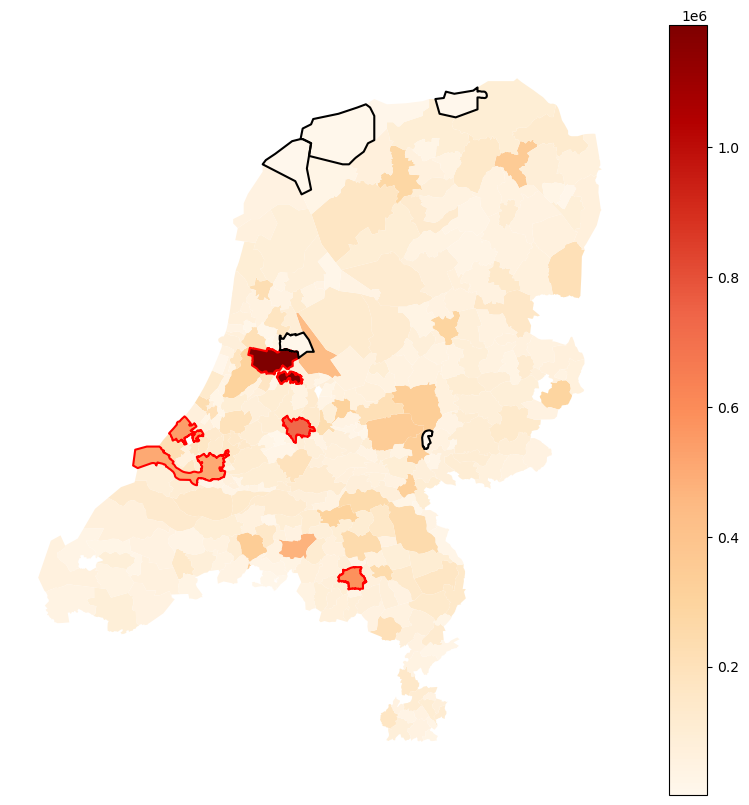

In [14]:
# embodied emissions total
query = ''' 
WITH emissions AS (
	SELECT municipality, SUM(emissions_embodied_tons) AS emissions_embodied_tons
	FROM emissions_embodied_housing_nl 
	WHERE year >= 2011 AND year <= 2022 -- AND municipality = 'Delft'
	GROUP BY municipality
)
SELECT e.*, g.geom
FROM emissions e 
JOIN nl_gemeentegebied g 
ON e.municipality = g.naam
ORDER BY e.emissions_embodied_tons DESC
'''
gdf = gpd.read_postgis(query, engine)

# top and bottom five municipalities 
top_five = gdf.head().municipality.tolist()
bottom_five = gdf.tail().municipality.tolist()
print(f'Top ten municipalities: {top_five}')
print(f'Bottom ten municipalities: {bottom_five}')

# plot on map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='emissions_embodied_tons', legend=True, cmap='OrRd', ax=ax)
gdf.head().boundary.plot(ax=ax, color='red')
gdf.tail().boundary.plot(ax=ax, color='black')
ax.axis('off')
plt.show()

In [15]:
# horizontal bar chart for embodied emissions per municipality
fig = px.bar(gdf, x='emissions_embodied_tons', y='municipality', title='Embodied emissions per municipality for housing in NL')
fig.update_layout(width=800, height=800)
fig.show()

In [9]:
# by status
query = f'''
SELECT municipality, status, SUM(sqm) AS sqm, SUM(emissions_embodied_tons) AS emissions_embodied_tons
FROM emissions_embodied_housing_nl
WHERE 
    municipality IN ('Amsterdam', 'Utrecht', 'Tilburg', 'Eindhoven', \'\'\'s-Gravenhage')
    AND year >= 2011 AND year < 2024
GROUP BY municipality, status
'''
df = pd.read_sql_query(query, engine)

municipality_order = ['Amsterdam', 'Utrecht', 'Tilburg', 'Eindhoven', "'s-Gravenhage"]
status_order = ['Verbouwing pand', 'Pand gesloopt', 'Bouw gestart']
fig = px.bar(df, x='municipality', y='emissions_embodied_tons', color='status', barmode='group', 
             title='Embodied emissions by status for top five municipalities (2011 - 2024)', 
             category_orders={'municipality': municipality_order, 'status': status_order})
fig.update_layout(width=1000)
fig.show()  

In [24]:
query = ''' 
SELECT year, municipality, SUM(emissions_embodied_tons) AS emissions_embodied_tons
FROM emissions_embodied_housing_nl 
WHERE year >= 2011 AND year <= 2022 
GROUP BY year, municipality
ORDER BY year, municipality
'''
df = pd.read_sql_query(query, engine)
df['cumulative_emissions'] = df.sort_values('year').groupby('municipality')['emissions_embodied_tons'].cumsum()
df = df[df['municipality'].isin(top_five + bottom_five)]

fig = px.line(df, x='year', y='cumulative_emissions', color='municipality', title='Cumulative embodied emissions per year for housing in NL')
fig.show()

In [21]:
# emissions for one municipality
def get_data_for_municipality(municipality_name, engine): 
    query = f''' 
    SELECT year, SUM(emissions_embodied_tons) AS emissions_embodied_tons
    FROM emissions_embodied_housing_nl 
    WHERE year >= 2011 AND year <= 2022 AND municipality = '{municipality_name}'
    GROUP BY year
    '''
    df = pd.read_sql_query(query, engine)    
    df['cumulative_emissions'] = df['emissions_embodied_tons'].cumsum()
    
    return df 

def plot_embodiedEmissions_perYear_forMunicipality(df, municipality_name, type='cumulative'):
    if type == 'cumulative':
        title = f'Cumulative embodied emissions per year for housing in {municipality_name}'
        y = 'cumulative_emissions'
    else: 
        title = 'Embodied emissions per year for housing in ' + municipality_name
        y = 'emissions_embodied_tons'
    
    fig = px.line(df, x='year', y=y, title=title)
    fig.show()

municipality_name = 'Amsterdam'
df = get_data_for_municipality(municipality_name, engine)
plot_embodiedEmissions_perYear_forMunicipality(df, municipality_name, 'n cumulative')
plot_embodiedEmissions_perYear_forMunicipality(df, municipality_name, 'cumulative')